# <center>Audio Emotion Recognition</center>
## <center>Part 5 - Data augmentation</center>
#### <center> 7th September 2019 </center> 
#####  <center> Eu Jin Lok </center> 

## Introduction 
Continuing where we left off in [Part 3](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model) where we built a simple baseline model, now we're going to take the next level up and build in some data augmentation methods. I did some reading and desk reseach and there's a few good articles around on this:

- [Edward Ma](https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6)
- [Qishen Ha](https://www.kaggle.com/haqishen/augmentation-methods-for-audio)
- [Reza Chu](https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3)

Thanks to the various authors above, I've incorporated their methods into this notebook here. We'll go ahead and test a few methods for the authors, then implement some using the same 1D CNN model we used before so we can compare apples with apples exactly how much the accuracy contribution came from the data augmentation methods. 

1. [Explore augmentation methods](#explore)
    - [Static noise](#static)
    - [Shift](#shift)
    - [Stretch](#stretch)
    - [Pitch](#pitch)
    - [Dynamic change](#dynamic)
    - [Speed and pitch](#speed)
2. [Data preparation and processing](#data)
3. [Modelling](#modelling)
4. [Model serialisation](#serialise)
5. [Model validation](#validation)
6. [Final thoughts](#final)

Most importantly, I want to thank the 4 authors for their excellent dataset, without it, writing this notebook could not have been possible. The original source of the dataset links are below:
- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)

In [ ]:
# Keras
import keras
from keras import regularizers
from keras_preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras import Sequential, Model
from keras._tf_keras.keras.models import model_from_json
from keras._tf_keras.keras.layers import Dense, Embedding, LSTM, Input, Flatten, Dropout, Activation, \
    BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras._tf_keras.keras.utils import to_categorical
from keras._tf_keras.keras.callbacks import ModelCheckpoint
from keras._tf_keras.keras import utils
from keras._tf_keras.keras import optimizers
import np_utils

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other
import librosa
from librosa import feature
import json
from scipy.io import wavfile
from python_speech_features import mfcc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
from tqdm import tqdm
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

import sys
import warnings

In [ ]:
#########################
# Augmentation methods
#########################
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate=0.8)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), sr=sampling_rate, n_steps=pitch_change, bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<a id="explore"></a>
## 1. Explore augmentation method
So before we go full scale application of the augmentation methods, lets take one audio file and run it through all the different types to get a feel for how they work. From there we'll then take a few forward for our model training and hopefully it improves our accuracy.

We'll start with the orginal audio file untouched...

In [ ]:
# Use one audio file in previous parts again
fname = r"C:\Users\eo19181\Documents\All -  Datasets\TESS - Dataset\Female\Fear\OAF_goose_fear.wav"  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Paly it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

<a id="static"></a>
### Static noise 
The first augmentation method we'll do is to add static noise in the background. Here's how it sounds...

In [ ]:
x = noise(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

-------------------------
That's sounds like a good augmentation, not too much static such that it doesn't obfuscate the signal too much. 

<a id="shift"></a>
### Shift
Next method is shift...

In [ ]:
x = shift(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

----------------------------
So its not very noticable but what I've done there is move the audio randomly to either the left or right direction, within the fix audio duration. So if you compare this to the original plot, you can see the same audio wave pattern, except there's a tiny bit of delay before the speaker starts speaking. 

<a id="stretch"></a>
### Stretch 
Now we go to stretch, my most favourite augmentation method 

In [ ]:
x = stretch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

This one is one of the more dramatic augmentation methods. The method literally stretches the audio. So the duration is longer, but the audio wave gets strecthed too. Thus introducing and effect that sounds like a slow motion sound. If you look at the audio wave itself, you'll notice that compared to the orginal audio, the strected audio seems to hit a higher frequency note. Thus creating a more diverse data for augmentation. Pretty nifty eh? It does introduce abit of a challenge in the data prep stage cause it lengthens the audio duration. Something to consider especially when doing a 2D CNN. 
 
 <a id="pitch"></a>
### Pitch
I believe, this method accentuates the high pitch notes, by... normalising it sort of. 

In [ ]:
x = pitch(data, sampling_rate)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

Honestly, I'm not exactly sure how this pitch augmentation works. so I'll need to do more reading on this. But safe to say it's another way of augmenting the data. If you listen to it, you can hear the difference. 

<a id="dynamic"></a>
### Dynamic change
Dynamic change.... 

In [ ]:
x = dyn_change(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

----------------------------
Yes I know what you are thinking. It's exactly the same as the original. Yes true, but if you look at the frequency, the wave hits higher frequency notes compared to the original where the min is around -1 and the max is around 1. The min and max of this audio is -6 and 6 respestively. Not exactly sure how useful this is, I'll need to do some more reading.

<a id="speed"></a>
### Speed and pitch
Last but not least, speed and pitch...

In [ ]:
x = speedNpitch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

I really like this augmentation method. It dramatically alters the audio in many ways. It compresses the audio wave but keeping the audio duration the same. If you listen to it, the effect is opposite of the stretch augmentation method. An angry person when applied this augmentation method, to the human ear, will really alter the emotion interpretation of this audio. Not sure if this is counter productive to the algorithm, but lets try it. Another potential, downside is that there will be silence in the later part of the audio.  

<a id="data"></a>
## 2. Data preparation and processing
I'm going to use just 2 augmentation method which is the noise, and the speed & pitch method. Just for demo purposes. So now lets apply it across all our audio data. We'll use the same data processing steps we followed in [part 3](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model), except we add in the augmentation process in the loop. We are going to use the noise and speed pitch augmentation method

Actually I have also added one extra enhancement to the code, which is a progress bar using the tqdm library. Given that we're adding a few extra processing steps, it would be worthwhile to know how long we've progressed...

In [ ]:
# lets pick up the meta-data that we got from our first part of the Kernel


ref = pd.read_csv(r"C:\Users\eo19181\Documents\All -  Datasets\data_paths.csv")
ref.head()

In [ ]:
# Note this takes a couple of minutes (~16 mins) as we're iterating over 4 datasets, and with augmentation  
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(ref.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df.head()

Right so ~13 mins for completion, so its definitely longer, almost double the amount of time with the 2 augmentation methods in the loop. Instead of the one data object that we get out, we now get 2 other ones, one for each of the 2 augmentation methods we've used. 

We'll need to stack them on top of each other to make a larger dataset. But before we do so, we need to make sure the number of columns for the 3 datasets are the same. So lets check it out before we stack them 

_NOTE: If using the stretch augmentation, the audio duration becomes artifically longer and thus the number of columns will be different from original. So some padding will need to be done to the original dataset_

In [ ]:
# combine 
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([ref,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

Great so the shape of all the 3 datasets are the same. Thats expected. So our new dataset once stacked on top, will be 3 times the original size, which is handy since Deep Learning needs alot of data

In [ ]:
df = pd.concat([df,df_noise,df_speedpitch],axis=0,sort=False)
df=df.fillna(0)
del df_noise, df_speedpitch

df.head()

So now after stacking them, we'll go ahead and split the dataset as per the usual...

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

... and then we normalise our dataset

In [ ]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

... make the dataset keras compatible

In [ ]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

<a id="modelling"></a>
## 3. Modelling
We're going to use the same model architecture that was in part 3 so we can compare apples with apples...thou a note of caution that the model build will take close to an hour even with GPU

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test),verbose=2)

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Notice that I've increased the number of epochs to 150 in this notebook. Now if you recall in Part 3, we set to 100 epochs and the logloss plot shows that it has reached full potential at a logloss of about 1.6 after about 50 epochs, and further epochs doesn't really make it more accuracy anymore. With data augmentation however, it seems to indicate that it hasn't quite plateau yet and could still get better. 

And so that's why i've increased the number of epochs so it can achieve its full potential. Originally when I set to 100 epochs, the plot indicated it hasn't plateau. So i reran at 150 and you can see cleary now that around 100 epochs diminishing returns sets in. I'm going to keep the final model at 150 instead of 100. 

<a id="serialise"></a>
## 4. Model serialisation
So we serialise the model...

In [ ]:
# Save model and weights
model_name = 'Emotion_Model_aug.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_aug.json", "w") as json_file:
    json_file.write(model_json)

<a id="validation"></a>
## 5. Model validation
So if you recall in part 3, the model accuracy at 100 epochs was at 43.80%... 

In [ ]:
# loading json and model architecture 
json_file = open('model_json_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_aug.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

We now have 48.41%. Yes it is at 150 epochs but even at 100 it would yeild rougly the same results as per illustrated on the plot above. So now lets run it through the test set.

In [ ]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

Then append the labels to it before we run the accuracy measure...

In [ ]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

Lets write the predictions out into a file for re-use

In [ ]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

So how well have we done? Have we made a significant improvement? 

#### Emotion by gender accuracy  
So lets visualise how well we have done for the Emotion by Gender model

In [ ]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

The accuracy for the gender by emotions in Part 3 is 43%, and we got 48%, which is great. A small but not unexpected uplift given we only introduce 2 augmentation methods. 

---------------
#### Gender accuracy result 
if you notice, that the gender classification is more accurate. So lets group them up and measure the accuracy again?

In [ ]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

With data augmentation we get 80.8% compared to 80.4% without augmentation. So not much difference when differentiating by gender. 

#### Emotion accuracy
We'll now ignore the gender part and just super group them into the 7 core emotions. Lets see what we get...

0.5138220883714658


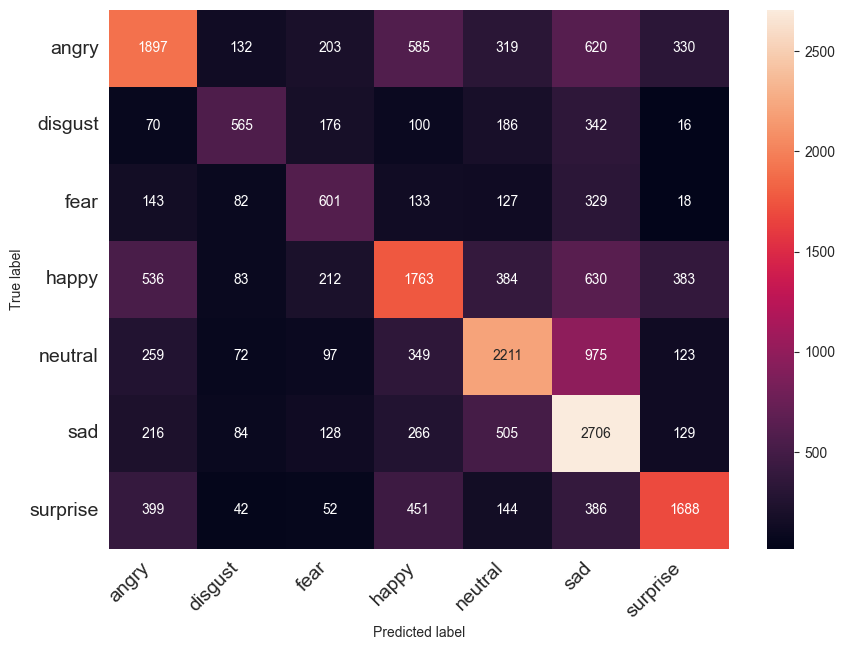

In [112]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [113]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.54      0.46      0.50      4086
     disgust       0.53      0.39      0.45      1455
        fear       0.41      0.42      0.41      1433
       happy       0.48      0.44      0.46      3991
     neutral       0.57      0.54      0.56      4086
         sad       0.45      0.67      0.54      4034
    surprise       0.63      0.53      0.58      3162

    accuracy                           0.51     22247
   macro avg       0.52      0.49      0.50     22247
weighted avg       0.52      0.51      0.51     22247



54% compared to 49% without data augmentation. 

<a id="final"></a>
## 6. Final thoughts 
So its quite clear that data augmentation does help improve the accuracy albeit slightly. Note that we only introduced 2 augmentation methods. Perhaps if we include more it may make it more accurate. But there comes to a point where we have to consider the trade off between speed and accuracy. 

Next section we're going to look at implementing more advance modelling techniques. And of course, we'll be bringing forward this 2 augmentation methods that we just do today